# Feature extraction using VGG16

In [15]:
# tf tools
import tensorflow as tf

# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
# VGG16 model
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)
# cifar10 data - 32x32
from tensorflow.keras.datasets import cifar10

# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout, 
                                     BatchNormalization)
# generic model object
from tensorflow.keras.models import Model

# optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD

#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# for plotting
import numpy as np
import matplotlib.pyplot as plt

## Plotting function (from last week)

In [16]:
def plot_history(H, epochs):
    plt.style.use("seaborn-colorblind")

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss", linestyle=":")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc", linestyle=":")
    plt.title("Accuracy curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend()
    plt.show()

## Initialize the model

In [17]:
# load the model
model = VGG16()

__Preprocessing__

Keras provides some tools to help with this step.

First, we can use the ```load_img()``` function to load the image and resize it to the required size of 224×224 pixels.

In [18]:
# load an image from file
image = load_img('../data/img/florence.jpg', target_size=(224, 224))

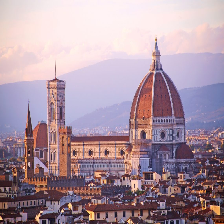

In [19]:
image

Next, we can convert the pixels to a NumPy array so that we can work with it in Keras. 

We can use the ```img_to_array()``` function for this.

In [20]:
# convert the image pixels to a numpy array
image = img_to_array(image)

The network expects one or more images as input; that means the input array will need to be 4-dimensional: samples, rows, columns, and channels.

We only have one sample (one image). We can reshape the array by calling ```reshape()``` and adding the extra dimension.

In [21]:
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

Next, the image pixels need to be prepared in the same way as the ImageNet training data was prepared. Specifically, from the paper:

>The only preprocessing we do is subtracting the mean RGB value, computed on the training set, from each pixel. 

See the paper [here](https://arxiv.org/abs/1409.1556).

In [22]:
# prepare the image for the VGG model
image = preprocess_input(image)

## Make prediction using ImageNet labels

We then use the model to predict our image class and convert probabilities to class labels using ```decode_predictions()```.

In [23]:
# predict the probability across all output classes
y_pred = model.predict(image)
# convert the probabilities to class labels
label = decode_predictions(y_pred)

1/1 [==============================] - 0s 458ms/step


__Inspect most likely label__

In [24]:
label

[[('n03220513', 'dome', 0.45702526),
  ('n03028079', 'church', 0.301825),
  ('n03877845', 'palace', 0.04829808),
  ('n02930766', 'cab', 0.026109034),
  ('n02825657', 'bell_cote', 0.024095427)]]

## Finetune on new task

We import the regular cifar10 dataset from ```keras``` and normalise.

In [25]:
((X_train, y_train), (X_test, y_test)) = cifar10.load_data()
X_train = X_train.astype("float") / 255.
X_test = X_test.astype("float") / 255.

In [26]:
X_train

array([[[[0.23137255, 0.24313725, 0.24705882],
         [0.16862745, 0.18039216, 0.17647059],
         [0.19607843, 0.18823529, 0.16862745],
         ...,
         [0.61960784, 0.51764706, 0.42352941],
         [0.59607843, 0.49019608, 0.4       ],
         [0.58039216, 0.48627451, 0.40392157]],

        [[0.0627451 , 0.07843137, 0.07843137],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509804, 0.21568627],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117647, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215686, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941176, 0.19607843],
         [0.47058824, 0.32941176, 0.19607843],
         [0.42745098, 0.28627451, 0.16470588]],

        ...,

        [[0.81568627, 0.66666667, 0.37647059],
         [0.78823529, 0.6       , 0.13333333]

__Binarize labels__

In [27]:
# integers to one-hot vectors
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

# initialize label names for CIFAR-10 dataset
labelNames = ["airplane", "automobile", 
              "bird", "cat", 
              "deer", "dog", 
              "frog", "horse", 
              "ship", "truck"]

__Check tensor shape__

In [28]:
X_train.shape

(50000, 32, 32, 3)

__Load VGG16 *without* the classification layers__

Here we're just loading the convolutional layers and not the final classification network, using the argument ```include_top=False```

We also redefine the input shape, to work better with our cifar10 data.

In [29]:
# load model without classifier layers
model = VGG16(include_top=False, 
              pooling='avg',
              input_shape=(32, 32, 3))

__Disable training of Conv layers__

We need to disable the convolutional layers before training. Why?

In [30]:
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False

In [31]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

__Add new classification layers__

We now add new classification layers after the convolutional layers.

Notice how here we are not using the ```Sequential```, so we have to explicitly name the preceding layer in the model!

In [32]:
tf.keras.backend.clear_session()

In [33]:
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, activation='relu')(flat1)
output = Dense(10, activation='softmax')(class1)

# define new model
model = Model(inputs=model.inputs, 
              outputs=output)
# summarize
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

__Compile__

We're going to be using a more sophisticated optimization algorithm, which you can read about [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay).

In [34]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,#learning rate 
    decay_steps=10000,# så mange steps før learning rate decayer
    decay_rate=0.9)#decay rate
sgd = SGD(learning_rate=lr_schedule)

In [35]:
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

__Train__

In [36]:
H = model.fit(X_train, y_train, 
            validation_split=0.1,
            batch_size=128,
            epochs=10,
            verbose=1)

Epoch 1/10
352/352 [==============================] - 76s 214ms/step - loss: 2.0456 - accuracy: 0.2907 - val_loss: 1.8213 - val_accuracy: 0.4056
Epoch 2/10
352/352 [==============================] - 73s 207ms/step - loss: 1.7413 - accuracy: 0.4191 - val_loss: 1.6441 - val_accuracy: 0.4478
Epoch 3/10
352/352 [==============================] - 74s 210ms/step - loss: 1.6113 - accuracy: 0.4523 - val_loss: 1.5415 - val_accuracy: 0.4854
Epoch 4/10
352/352 [==============================] - 75s 212ms/step - loss: 1.5368 - accuracy: 0.4713 - val_loss: 1.4907 - val_accuracy: 0.4950
Epoch 5/10
352/352 [==============================] - 75s 214ms/step - loss: 1.4874 - accuracy: 0.4891 - val_loss: 1.4464 - val_accuracy: 0.5082
Epoch 6/10
352/352 [==============================] - 75s 215ms/step - loss: 1.4504 - accuracy: 0.5009 - val_loss: 1.4180 - val_accuracy: 0.5074
Epoch 7/10
352/352 [==============================] - 75s 214ms/step - loss: 1.4220 - accuracy: 0.5105 - val_loss: 1.3929 - val_ac

__Evaluate__

/tmp/ipykernel_35654/3716877966.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


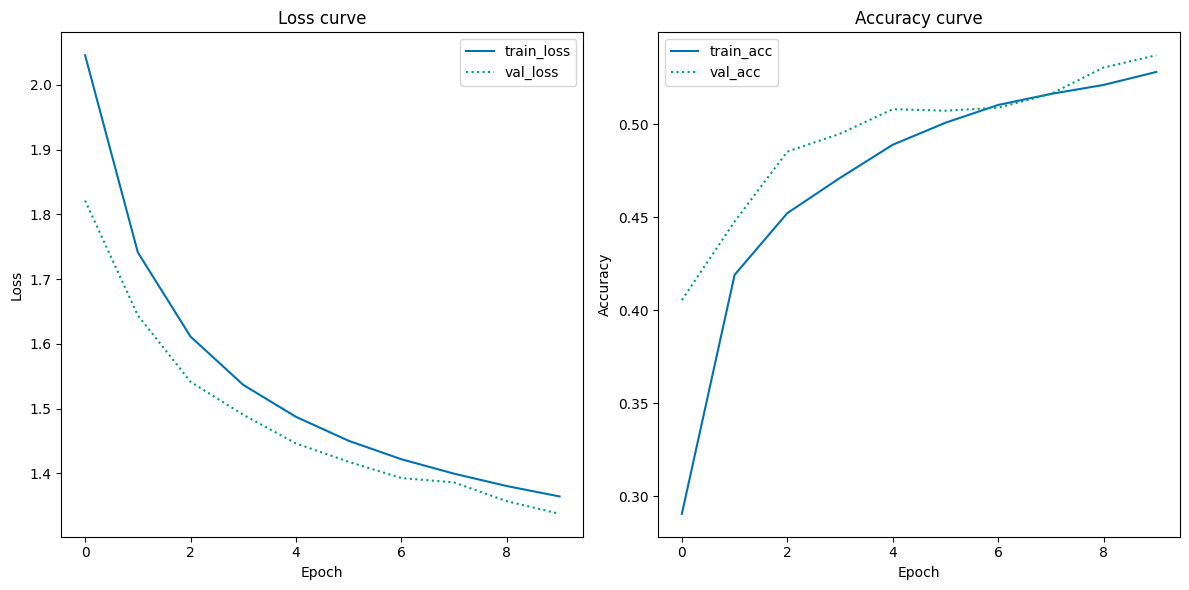

In [37]:
plot_history(H, 10)

In [38]:
predictions = model.predict(X_test, batch_size=128)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=labelNames))

79/79 [==============================] - 15s 191ms/step
              precision    recall  f1-score   support

    airplane       0.60      0.57      0.59      1000
  automobile       0.52      0.63      0.57      1000
        bird       0.46      0.34      0.39      1000
         cat       0.38      0.38      0.38      1000
        deer       0.49      0.52      0.51      1000
         dog       0.50      0.45      0.47      1000
        frog       0.58      0.61      0.59      1000
       horse       0.54      0.58      0.56      1000
        ship       0.58      0.67      0.62      1000
       truck       0.55      0.47      0.51      1000

    accuracy                           0.52     10000
   macro avg       0.52      0.52      0.52     10000
weighted avg       0.52      0.52      0.52     10000



## Using data augmentation

__Reload model__

In [39]:
del model
tf.keras.backend.clear_session()

In [42]:
# load model without classifier layers
model = VGG16(include_top=False, 
              pooling='avg',
              input_shape=(32, 32, 3))

# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
    
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
bn = BatchNormalization()(flat1)
class1 = Dense(256, 
               activation='relu')(bn)
class2 = Dense(128, 
               activation='relu')(class1)
output = Dense(10, 
               activation='softmax')(class2)

# define new model
model = Model(inputs=model.inputs, 
              outputs=output)

# compile
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
sgd = SGD(learning_rate=lr_schedule)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# summarize
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

__Define data generator__

You can see the documentation for ImageDataGenerator [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [43]:
# flip along x axis (mirror image)
datagen = ImageDataGenerator(horizontal_flip=True, 
                             rotation_range=20)

We're choosing to generate data on the fly, rather than save it to a folder.

__Train__

In [44]:
# fit the data generator to our images
datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:
H = model.fit(datagen.flow(X_train, y_train, batch_size=128), 
              validation_data = datagen.flow(X_train, y_train, batch_size=128, subset = "validation"),
            epochs=10)

ValueError: Training and validation subsets have different number of classes after the split. If your numpy arrays are sorted by the label, you might want to shuffle them.

__Inspect__

In [ ]:
plot_history(H, 10)

__Evaluate__

In [ ]:
predictions = model.predict(X_test, batch_size=128)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=labelNames))